In [ ]:
# ============================================================
# PTPN2-ONLY CRISPR RL with PCA+GAT + Multi-Step Trajectories
# MODEL-BASED RL (PERTURB ONCE, THEN WORLD MODEL)
#
# FEATURES:
#   ✔ Pseudotime-aware starting state (PTPN2 only)
#   ✔ PCA → GAT (inference-only) fused latent
#   ✔ World model fθ learned from kNN pseudotime next-step
#   ✔ Multi-step model-based RL forecasting
#   ✔ Pseudotime-aligned evaluation (PTPN2-only)
#   ✔ PPO, TRPO, TRPO→PPO multistage
# ============================================================

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import sparse
from scipy.spatial.distance import cdist
import math

import scanpy as sc
import anndata as ad

import gymnasium as gym
from gymnasium import spaces

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score,
    average_precision_score
)

import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.env_checker import check_env

import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 1. Paths / Hyperparameters
# ============================================================

PTPN2_MATRIX = "GSM3937879_Ptpn2_matrix.mtx"
PTPN2_FEAT   = "GSM3937879_Ptpn2_features.tsv"

N_TOP_GENES = 20
N_PCS       = 10
GAT_OUT_DIM = 32

WORLD_HIDDEN  = 128   # world model hidden size

ACTION_SCALE = 0.3
HORIZON      = 12  # multi-step trajectory length

PPO_TIMESTEPS_BASELINE = 200_000
TRPO_TIMESTEPS_STAGE1  = 50_000
PPO_TIMESTEPS_STAGE2   = 150_000

ROLLOUT_SAMPLES = 1500
K_NEXT          = 5      # kNN for world-model training
WORLD_EPOCHS    = 50
BATCH_SIZE      = 256
WORLD_LR        = 1e-3
ALPHA_PT_DELTA  = 1e-4   # min pseudotime gap for "future" neighbors


# ============================================================
# 2. Load PTPN2 matrix (ONLY PTPN2, NO CTRL)
# ============================================================

def load_mtx(mtx_path, feat_path):
    X = sio.mmread(mtx_path)
    if not sparse.isspmatrix(X):
        X = sparse.coo_matrix(X)
    X = X.T.tocsr()  # cells × genes
    genes = pd.read_csv(feat_path, sep="\t", header=None).iloc[:, 0].astype(str).values
    return X, genes

ptpn2_X, ptpn2_genes = load_mtx(PTPN2_MATRIX, PTPN2_FEAT)
adata = ad.AnnData(ptpn2_X)
adata.var_names = ptpn2_genes
adata.obs["condition"] = "PTPN2"

print("PTPN2 raw:", adata.shape)


# ============================================================
# 3. Preprocessing + PCA (PTPN2 only)
# ============================================================

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=N_TOP_GENES, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=N_PCS)

X_pca = adata.obsm["X_pca"]      # (n_cells, N_PCS)
n_cells = X_pca.shape[0]
print("PCA embedding:", X_pca.shape)


# ============================================================
# 4. Pseudotime via Diffusion Maps (PTPN2 only)
# ============================================================

sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca")
sc.tl.diffmap(adata)

# Root = mid PTPN2 cell (any reasonable choice)
iroot = n_cells // 2
adata.uns["iroot"] = iroot

sc.tl.dpt(adata)
pseudotime = adata.obs["dpt_pseudotime"].values.astype(np.float32)
print("Pseudotime:", pseudotime.shape)


# ============================================================
# 5. GAT Embedding (Inference-only, like CTRL pipeline)
# ============================================================

A = adata.obsp["connectivities"].tocsr()

neighbor_lists = []
for i in range(A.shape[0]):
    neigh = A[i].indices
    if i not in neigh:
        neigh = np.append(neigh, i)
    neighbor_lists.append(neigh)

class SimpleGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, neighbors, alpha=0.2):
        super().__init__()
        self.neighbors = neighbors
        self.W = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.a = nn.Parameter(torch.Tensor(2 * out_dim, 1))
        self.leakyrelu = nn.LeakyReLU(alpha)
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.a)

    def forward(self, X):
        Wh = X @ self.W  # (N, out_dim)
        out = torch.zeros_like(Wh)
        for i in range(Wh.shape[0]):
            neigh = self.neighbors[i]
            h_i = Wh[i]
            h_j = Wh[neigh]
            k = len(neigh)
            h_i_rep = h_i.expand(k, -1)
            a_input = torch.cat([h_i_rep, h_j], dim=1)
            e = self.leakyrelu(a_input @ self.a).squeeze(-1)
            alpha = torch.softmax(e, dim=0)
            out[i] = (alpha.unsqueeze(1) * h_j).sum(0)
        return out

gat_layer = SimpleGATLayer(N_PCS, GAT_OUT_DIM, neighbor_lists).to(DEVICE)
with torch.no_grad():
    X_gat = gat_layer(torch.tensor(X_pca, dtype=torch.float32, device=DEVICE)).cpu().numpy()

emb_all = np.concatenate([X_pca, X_gat], axis=1).astype(np.float32)
print("Fused PCA+GAT embedding:", emb_all.shape)


# ============================================================
# 6. PTPN2 TRAIN / TEST SPLIT (80/20) + pseudotime
# ============================================================

emb_train, emb_test, pt_train, pt_test = train_test_split(
    emb_all, pseudotime, test_size=0.20, random_state=42, shuffle=True
)

print("PTPN2 train latent:", emb_train.shape)
print("PTPN2 test latent:",  emb_test.shape)


# ============================================================
# 7. REAL TARGET (PTPN2 TRAIN MEAN)
# ============================================================

target_ptpn2_real = emb_train.mean(axis=0).astype(np.float32)
print("Target latent dim:", target_ptpn2_real.shape)


# ============================================================
# 8. World model fθ: kNN denoised next-step along pseudotime (TRAIN only)
# ============================================================

def build_world_model_pairs(emb, pt, k=5, min_delta=1e-4):
    """
    For each train cell i:
      - Find candidates j with pt_j > pt_i + min_delta
      - Among them, pick k nearest in embedding space
      - Define x_next_i as mean of those neighbors
    Returns arrays X_curr, X_next
    """
    n = emb.shape[0]
    X_curr, X_next = [], []
    for i in range(n):
        mask = pt > pt[i] + min_delta
        cand_idx = np.where(mask)[0]
        if len(cand_idx) < k:
            continue
        cand_emb = emb[cand_idx]
        dists = np.linalg.norm(cand_emb - emb[i], axis=1)
        nn_rel = np.argsort(dists)[:k]
        nn_abs = cand_idx[nn_rel]
        x_next = emb[nn_abs].mean(axis=0)
        X_curr.append(emb[i])
        X_next.append(x_next)
    X_curr = np.vstack(X_curr)
    X_next = np.vstack(X_next)
    return X_curr.astype(np.float32), X_next.astype(np.float32)

X_curr_wm, X_next_wm = build_world_model_pairs(
    emb_train, pt_train, k=K_NEXT, min_delta=ALPHA_PT_DELTA
)
print("World model pairs:", X_curr_wm.shape, X_next_wm.shape)


class WorldModel(nn.Module):
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        return self.net(x)


world_dim = emb_train.shape[1]
world_model = WorldModel(world_dim, WORLD_HIDDEN).to(DEVICE)
world_opt = torch.optim.Adam(world_model.parameters(), lr=WORLD_LR)
world_loss_fn = nn.MSELoss()

X_curr_tensor = torch.tensor(X_curr_wm, dtype=torch.float32, device=DEVICE)
X_next_tensor = torch.tensor(X_next_wm, dtype=torch.float32, device=DEVICE)

world_model.train()
for epoch in range(WORLD_EPOCHS):
    perm = torch.randperm(X_curr_wm.shape[0], device=DEVICE)
    total = 0.0
    for i in range(0, X_curr_wm.shape[0], BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch_curr = X_curr_tensor[idx]
        batch_next = X_next_tensor[idx]
        world_opt.zero_grad()
        pred_next = world_model(batch_curr)
        loss = world_loss_fn(pred_next, batch_next)
        loss.backward()
        world_opt.step()
        total += loss.item() * batch_curr.size(0)
    print(f"[WORLD] Epoch {epoch+1}/{WORLD_EPOCHS} | Loss={total/X_curr_wm.shape[0]:.4f}")

world_model.eval()


# ============================================================
# 9. MODEL-BASED RL ENVIRONMENT (PERTURB ONCE, THEN fθ)
# ============================================================

class PTPN2WorldEnv(gym.Env):
    """
    Model-based RL on PTPN2:
      - Only PTPN2 latent embeddings
      - Pseudotime-aware starting state
      - At t=0: RL applies a single perturbation (action) to initial state
      - For t>0: state evolves via world model fθ
      - Reward at each step: -||state - target||^2
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, emb, pt, target, world_model, horizon=12, action_scale=0.3):
        super().__init__()
        self.emb = emb.astype(np.float32)
        self.pt = pt.astype(np.float32)
        self.target = target.astype(np.float32)
        self.world_model = world_model
        self.horizon = horizon
        self.action_scale = action_scale

        self.n_cells, self.dim = self.emb.shape

        self.action_space = spaces.Box(-1.0, 1.0, (self.dim,), np.float32)
        self.observation_space = spaces.Box(-np.inf, np.inf, (self.dim,), np.float32)

        self.state = None
        self.t = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Pseudotime-aware sampling (later pseudotime slightly upweighted)
        pt_shifted = self.pt - self.pt.min() + 1e-6
        probs = pt_shifted / pt_shifted.sum()
        idx = np.random.choice(self.n_cells, p=probs)
        self.state = self.emb[idx].copy()
        self.t = 0
        return self.state, {}

    def step(self, action):
        if self.t == 0:
            # One-time KO perturbation at t=0
            action = np.clip(action, -1, 1)
            next_state = self.state + self.action_scale * action
        else:
            # Autonomous dynamics via world model fθ
            with torch.no_grad():
                s = torch.tensor(self.state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                next_state = self.world_model(s).cpu().numpy()[0]

        diff = next_state - self.target
        reward = -float(np.dot(diff, diff))

        self.state = next_state
        self.t += 1

        terminated = self.t >= self.horizon
        truncated = False
        return next_state, reward, terminated, truncated, {}


env_train = PTPN2WorldEnv(emb_train, pt_train, target_ptpn2_real,
                          world_model, horizon=HORIZON, action_scale=ACTION_SCALE)
env_test  = PTPN2WorldEnv(emb_test,  pt_test,  target_ptpn2_real,
                          world_model, horizon=HORIZON, action_scale=ACTION_SCALE)

check_env(env_train)


# ============================================================
# 10. TRAIN PPO Baseline, TRPO, TRPO→PPO
# ============================================================

ppo_baseline = PPO("MlpPolicy", env_train, verbose=1)
ppo_baseline.learn(total_timesteps=PPO_TIMESTEPS_BASELINE)

trpo_stage1 = TRPO("MlpPolicy", env_train, verbose=1)
trpo_stage1.learn(total_timesteps=TRPO_TIMESTEPS_STAGE1)

ppo_multistage = PPO("MlpPolicy", env_train, verbose=1)
ppo_multistage.policy.load_state_dict(trpo_stage1.policy.state_dict())
ppo_multistage.learn(total_timesteps=PPO_TIMESTEPS_STAGE2)


# ============================================================
# 11. Multi-step rollout (model-based trajectories)
# ============================================================

def rollout_multistep(model, env, n_samples=1000):
    raw, shifted, rewards = [], [], []

    for _ in range(n_samples):
        obs, _ = env.reset()
        start = obs.copy()
        total_r = 0.0

        for _ in range(env.horizon):
            act, _ = model.predict(obs, deterministic=True)
            obs, r, done, _, _ = env.step(act)
            total_r += r
            if done:
                break

        raw.append(start)
        shifted.append(obs.copy())
        rewards.append(total_r)

    return np.vstack(raw), np.vstack(shifted), np.array(rewards)


raw_ppo_train, shifted_ppo_train, rewards_ppo_train = rollout_multistep(ppo_baseline,  env_train, ROLLOUT_SAMPLES)
raw_ppo_test,  shifted_ppo_test,  rewards_ppo_test  = rollout_multistep(ppo_baseline,  env_test,  ROLLOUT_SAMPLES)

raw_ms_train, shifted_ms_train, rewards_ms_train = rollout_multistep(ppo_multistage, env_train, ROLLOUT_SAMPLES)
raw_ms_test,  shifted_ms_test,  rewards_ms_test  = rollout_multistep(ppo_multistage, env_test,  ROLLOUT_SAMPLES)

raw_trpo_train, shifted_trpo_train, rewards_trpo_train = rollout_multistep(trpo_stage1, env_train, ROLLOUT_SAMPLES)
raw_trpo_test,  shifted_trpo_test,  rewards_trpo_test  = rollout_multistep(trpo_stage1, env_test,  ROLLOUT_SAMPLES)


# ============================================================
# 12. Single-Mode Metrics (per latent dimension)
# ============================================================

def evaluate_single_dim(true_vals, pred_vals):
    m = {}

    y_true = (true_vals > 0).astype(int)
    y_pred = (pred_vals > 0).astype(int)

    m["Accuracy"]  = accuracy_score(y_true, y_pred)
    m["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    m["Recall"]    = recall_score(y_true, y_pred, zero_division=0)
    m["F1"]        = f1_score(y_true, y_pred, zero_division=0)

    try:
        m["AUPRC"] = average_precision_score(y_true, y_pred)
    except Exception:
        m["AUPRC"] = np.nan

    mse = mean_squared_error(true_vals, pred_vals)
    m["MSE"]  = mse
    m["RMSE"] = math.sqrt(mse)
    m["MAE"]  = mean_absolute_error(true_vals, pred_vals)
    m["R2"]   = r2_score(true_vals, pred_vals)

    if np.std(true_vals) == 0:
        m["Pearson"] = 0.0
    else:
        m["Pearson"] = np.corrcoef(true_vals, pred_vals)[0, 1]

    return m


def evaluate_model(raw, shifted, algo_name):
    results = []
    D = raw.shape[1]
    for d in range(D):
        vals = evaluate_single_dim(raw[:, d], shifted[:, d])
        vals["Dim"] = d
        vals["Algorithm"] = algo_name
        results.append(vals)
    df = pd.DataFrame(results)
    print(f"\n=== Metrics for {algo_name} ===")
    print(df.head())
    return df


df_ppo_train  = evaluate_model(raw_ppo_train,  shifted_ppo_train,  "PPO (Train)")
df_ppo_test   = evaluate_model(raw_ppo_test,   shifted_ppo_test,   "PPO (Test)")

df_ms_train   = evaluate_model(raw_ms_train,   shifted_ms_train,   "TRPO→PPO (Train)")
df_ms_test    = evaluate_model(raw_ms_test,    shifted_ms_test,    "TRPO→PPO (Test)")

df_trpo_train = evaluate_model(raw_trpo_train, shifted_trpo_train, "TRPO (Train)")
df_trpo_test  = evaluate_model(raw_trpo_test,  shifted_trpo_test,  "TRPO (Test)")

df_all = pd.concat([
    df_ppo_train, df_ppo_test,
    df_ms_train,  df_ms_test,
    df_trpo_train, df_trpo_test
], axis=0)

df_all.to_csv("ptpn2_world_model_single_mode_metrics_train_test.csv", index=False)


# ============================================================
# 13. Mean metrics per algorithm (Train vs Test)
# ============================================================

metric_cols = [
    "Accuracy","Precision","Recall","F1",
    "AUPRC","MSE","RMSE","MAE","R2","Pearson"
]

df_mean = df_all.groupby("Algorithm")[metric_cols].mean()
df_mean.to_csv("ptpn2_world_model_mean_metrics_train_vs_test.csv")

print("\n=========== MEAN METRICS PER ALGORITHM (Train vs Test) ===========")
print(df_mean)


# ============================================================
# 14. Distance-to-target validation (internal, PTPN2-only)
# ============================================================

def mean_dist_to_target(X, target):
    return np.linalg.norm(X - target[None, :], axis=1).mean()

print("\n=== Distance to REAL PTPN2 TRAIN MEAN (Test set) ===")

baseline_dist_real_test = mean_dist_to_target(emb_test,         target_ptpn2_real)
ppo_dist_real_test      = mean_dist_to_target(shifted_ppo_test, target_ptpn2_real)
ms_dist_real_test       = mean_dist_to_target(shifted_ms_test,  target_ptpn2_real)
trpo_dist_real_test     = mean_dist_to_target(shifted_trpo_test,target_ptpn2_real)

print(f"Baseline TEST → real PTPN2 mean: {baseline_dist_real_test:.4f}")
print(f"PPO(TEST) → real PTPN2 mean:     {ppo_dist_real_test:.4f}")
print(f"TRPO→PPO(TEST) → real PTPN2:     {ms_dist_real_test:.4f}")
print(f"TRPO(TEST) → real PTPN2:         {trpo_dist_real_test:.4f}")


# ============================================================
# 15. Pseudotime alignment of shifted TEST states (internal)
# ============================================================

def map_to_pseudotime(ref_emb, ref_pt, X):
    d = cdist(X, ref_emb)
    nn = d.argmin(axis=1)
    return ref_pt[nn]

pt_test_map  = pt_test
pt_ms_test   = map_to_pseudotime(emb_train, pt_train, shifted_ms_test)
pt_ppo_test  = map_to_pseudotime(emb_train, pt_train, shifted_ppo_test)
pt_trpo_test = map_to_pseudotime(emb_train, pt_train, shifted_trpo_test)

print("\n=== Pseudotime alignment (Test) ===")
print(f"Original Test pseudotime: mean={pt_test_map.mean():.3f}, std={pt_test_map.std():.3f}")
print(f"TRPO→PPO shifted:         mean={pt_ms_test.mean():.3f},  std={pt_ms_test.std():.3f}")
print(f"PPO shifted:              mean={pt_ppo_test.mean():.3f}, std={pt_ppo_test.std():.3f}")
print(f"TRPO shifted:             mean={pt_trpo_test.mean():.3f}, std={pt_trpo_test.std():.3f}")


# ============================================================
# 16. 2D Visualization (Test-set shift, PTPN2-only)
# ============================================================

ptpn2_train_2d = emb_train[:, :2]
ptpn2_test_2d  = emb_test[:, :2]
ms_test_2d     = shifted_ms_test[:, :2]   # TRPO→PPO on TEST

plt.figure(figsize=(9, 8))
plt.scatter(ptpn2_train_2d[:,0], ptpn2_train_2d[:,1],
            s=5, alpha=0.2, label="PTPN2 Train")
plt.scatter(ptpn2_test_2d[:,0],  ptpn2_test_2d[:,1],
            s=5, alpha=0.4, label="PTPN2 Test")
plt.scatter(ms_test_2d[:,0],    ms_test_2d[:,1],
            s=8, alpha=0.9, label="TRPO→PPO shifted (Test)")

plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("PTPN2 latent space: Train/Test and TRPO→PPO-shifted (World-model RL)")
plt.legend()
plt.tight_layout()
plt.show()


PTPN2 raw: (3775, 27998)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


PCA embedding: (3775, 10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Pseudotime: (3775,)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Fused PCA+GAT embedding: (3775, 42)
PTPN2 train latent: (3020, 42)
PTPN2 test latent: (755, 42)
Target latent dim: (42,)
World model pairs: (3014, 42) (3014, 42)
[WORLD] Epoch 1/50 | Loss=0.5543
[WORLD] Epoch 2/50 | Loss=0.3391
[WORLD] Epoch 3/50 | Loss=0.1633
[WORLD] Epoch 4/50 | Loss=0.0784
[WORLD] Epoch 5/50 | Loss=0.0451
[WORLD] Epoch 6/50 | Loss=0.0353
[WORLD] Epoch 7/50 | Loss=0.0321
[WORLD] Epoch 8/50 | Loss=0.0301
[WORLD] Epoch 9/50 | Loss=0.0289
[WORLD] Epoch 10/50 | Loss=0.0288
[WORLD] Epoch 11/50 | Loss=0.0275
[WORLD] Epoch 12/50 | Loss=0.0266
[WORLD] Epoch 13/50 | Loss=0.0260
[WORLD] Epoch 14/50 | Loss=0.0257
[WORLD] Epoch 15/50 | Loss=0.0253
[WORLD] Epoch 16/50 | Loss=0.0249
[WORLD] Epoch 17/50 | Loss=0.0242
[WORLD] Epoch 18/50 | Loss=0.0240
[WORLD] Epoch 19/50 | Loss=0.0236
[WORLD] Epoch 20/50 | Loss=0.0231
[WORLD] Epoch 21/50 | Loss=0.0229
[WORLD] Epoch 22/50 | Loss=0.0227
[WORLD] Epoch 23/50 | Loss=0.0224
[WORLD] Epoch 24/50 | Loss=0.0225
[WORLD] Epoch 25/50 | Loss=0.02

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

PTPN2 raw: (3775, 27998)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


PCA embedding: (3775, 10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and sc

Pseudotime: (3775,)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Fused PCA+GAT embedding: (3775, 42)
PTPN2 train latent: (3020, 42)
PTPN2 test latent: (755, 42)
Target latent dim: (42,)
World model pairs: (3014, 42) (3014, 42)
[WORLD] Epoch 1/50 | Loss=0.5971
[WORLD] Epoch 2/50 | Loss=0.3677
[WORLD] Epoch 3/50 | Loss=0.1874
[WORLD] Epoch 4/50 | Loss=0.1004
[WORLD] Epoch 5/50 | Loss=0.0575
[WORLD] Epoch 6/50 | Loss=0.0434
[WORLD] Epoch 7/50 | Loss=0.0382
[WORLD] Epoch 8/50 | Loss=0.0357
[WORLD] Epoch 9/50 | Loss=0.0349
[WORLD] Epoch 10/50 | Loss=0.0344
[WORLD] Epoch 11/50 | Loss=0.0328
[WORLD] Epoch 12/50 | Loss=0.0317
[WORLD] Epoch 13/50 | Loss=0.0312
[WORLD] Epoch 14/50 | Loss=0.0309
[WORLD] Epoch 15/50 | Loss=0.0300
[WORLD] Epoch 16/50 | Loss=0.0295
[WORLD] Epoch 17/50 | Loss=0.0293
[WORLD] Epoch 18/50 | Loss=0.0285
[WORLD] Epoch 19/50 | Loss=0.0285
[WORLD] Epoch 20/50 | Loss=0.0287
[WORLD] Epoch 21/50 | Loss=0.0273
[WORLD] Epoch 22/50 | Loss=0.0274
[WORLD] Epoch 23/50 | Loss=0.0267
[WORLD] Epoch 24/50 | Loss=0.0264
[WORLD] Epoch 25/50 | Loss=0.02

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== Metrics for PPO (Test) ===
   Accuracy  Precision    Recall        F1     AUPRC       MSE      RMSE  \
0  0.945333   0.684211  0.146067  0.240741  0.150608  0.082384  0.287026   
1  0.968667   1.000000  0.799145  0.888361  0.830479  0.161497  0.401867   
2  0.916667   0.783133  0.377907  0.509804  0.367285  0.301250  0.548863   
3  0.885333   0.715931  0.939547  0.812636  0.688650  0.131030  0.361980   
4  0.962667   0.954052  0.999125  0.976068  0.953884  0.156003  0.394973   

        MAE        R2   Pearson  Dim   Algorithm  
0  0.122774  0.456620  0.679396    0  PPO (Test)  
1  0.183404  0.654986  0.827798    1  PPO (Test)  
2  0.155872  0.383745  0.654912    2  PPO (Test)  
3  0.147309  0.552142  0.745306    3  PPO (Test)  
4  0.249606  0.630746  0.831089    4  PPO (Test)  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== Metrics for TRPO→PPO (Train) ===
   Accuracy  Precision    Recall        F1     AUPRC       MSE      RMSE  \
0  0.894000   0.846154  0.124294  0.216749  0.208505  0.268462  0.518133   
1  0.956667   0.987805  0.720000  0.832905  0.753220  0.176414  0.420016   
2  0.928667   0.898551  0.382716  0.536797  0.410556  0.251745  0.501742   
3  0.966667   0.946629  0.915761  0.930939  0.887553  0.115500  0.339853   
4  0.938000   0.939769  0.982744  0.960776  0.936885  0.183159  0.427971   

        MAE        R2   Pearson  Dim         Algorithm  
0  0.173027  0.253992  0.519307    0  TRPO→PPO (Train)  
1  0.194353  0.695258  0.866814    1  TRPO→PPO (Train)  
2  0.155705  0.363350  0.640959    2  TRPO→PPO (Train)  
3  0.129835  0.551730  0.743317    3  TRPO→PPO (Train)  
4  0.273700  0.573023  0.788768    4  TRPO→PPO (Train)  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== Metrics for TRPO→PPO (Test) ===
   Accuracy  Precision    Recall        F1     AUPRC       MSE      RMSE  \
0  0.923333   0.586207  0.141667  0.228188  0.151713  0.159455  0.399318   
1  0.956000   0.986301  0.774194  0.867470  0.805588  0.213837  0.462425   
2  0.913333   0.850575  0.387435  0.532374  0.407542  0.268781  0.518441   
3  0.958667   0.912833  0.935484  0.924020  0.871274  0.223604  0.472868   
4  0.954667   0.950218  0.989991  0.969697  0.948041  0.181125  0.425588   

        MAE        R2   Pearson  Dim        Algorithm  
0  0.160130  0.448293  0.700955    0  TRPO→PPO (Test)  
1  0.206336  0.621741  0.806969    1  TRPO→PPO (Test)  
2  0.170999  0.366479  0.642649    2  TRPO→PPO (Test)  
3  0.153545  0.421769  0.651345    3  TRPO→PPO (Test)  
4  0.285149  0.632356  0.829226    4  TRPO→PPO (Test)  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


=== Metrics for TRPO (Train) ===
   Accuracy  Precision    Recall        F1     AUPRC       MSE      RMSE  \
0  0.923333   0.560000  0.118644  0.195804  0.135774  0.119634  0.345881   
1  0.973333   0.977401  0.827751  0.896373  0.833045  0.112301  0.335113   
2  0.934000   0.888889  0.412903  0.563877  0.427692  0.263816  0.513630   
3  0.948000   0.917933  0.855524  0.885630  0.819314  0.116828  0.341801   
4  0.942000   0.931782  0.998280  0.963885  0.931513  0.204184  0.451868   

        MAE        R2   Pearson  Dim     Algorithm  
0  0.148923  0.374480  0.616357    0  TRPO (Train)  
1  0.175641  0.730555  0.855810    1  TRPO (Train)  
2  0.148405  0.388310  0.653019    2  TRPO (Train)  
3  0.144048  0.525601  0.735138    3  TRPO (Train)  
4  0.301956  0.516549  0.802192    4  TRPO (Train)  


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


=== Metrics for TRPO (Test) ===
   Accuracy  Precision    Recall        F1     AUPRC       MSE      RMSE  \
0  0.928667   0.735294  0.203252  0.318471  0.214783  0.117325  0.342528   
1  0.964667   0.958506  0.843066  0.897087  0.836750  0.230638  0.480248   
2  0.914000   0.878788  0.426471  0.574257  0.452777  0.350272  0.591838   
3  0.938000   0.915730  0.838046  0.875168  0.809424  0.282890  0.531874   
4  0.926667   0.908403  0.999076  0.951585  0.908230  0.277865  0.527129   

        MAE        R2   Pearson  Dim    Algorithm  
0  0.156467  0.396520  0.633407    0  TRPO (Test)  
1  0.237905  0.685146  0.836490    1  TRPO (Test)  
2  0.197356  0.375741  0.658998    2  TRPO (Test)  
3  0.211628  0.331914  0.603591    3  TRPO (Test)  
4  0.353951  0.461445  0.760231    4  TRPO (Test)  

=========== MEAN METRICS PER ALGORITHM (Train vs Test) ===========
                  Accuracy  Precision    Recall        F1     AUPRC       MSE  \
Algorithm                                        

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== Pseudotime alignment (Test) ===
Original Test pseudotime: mean=0.130, std=0.222
TRPO→PPO shifted:         mean=0.580,  std=0.391
PPO shifted:              mean=0.612, std=0.388
TRPO shifted:             mean=0.575, std=0.416


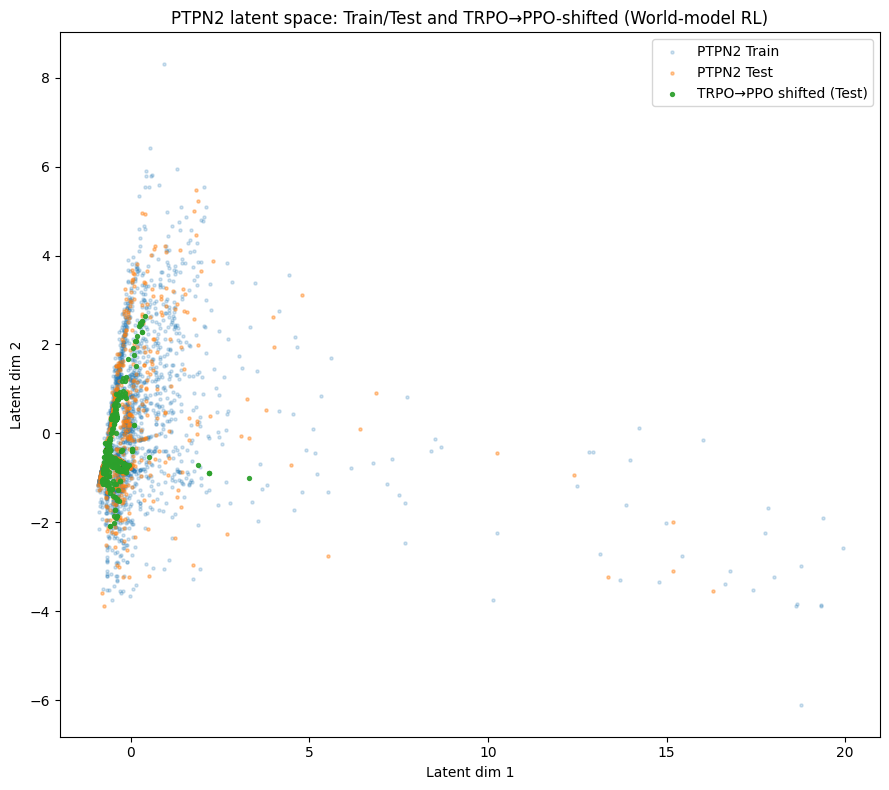

In [1]:
# ============================================================
# PTPN2-ONLY CRISPR RL with PCA+GAT + Multi-Step Trajectories
# MODEL-BASED RL (PERTURB ONCE, THEN WORLD MODEL)
#
# FEATURES:
#   ✔ Pseudotime-aware starting state (PTPN2 only)
#   ✔ PCA → GAT (inference-only) fused latent
#   ✔ World model fθ learned from kNN pseudotime next-step
#   ✔ Multi-step model-based RL forecasting
#   ✔ Pseudotime-aligned evaluation (PTPN2-only)
#   ✔ PPO, TRPO, TRPO→PPO multistage
# ============================================================

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import sparse
from scipy.spatial.distance import cdist
import math

import scanpy as sc
import anndata as ad

import gymnasium as gym
from gymnasium import spaces

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score,
    average_precision_score
)

import matplotlib.pyplot as plt

from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.env_checker import check_env

import torch
import torch.nn as nn

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ============================================================
# 1. Paths / Hyperparameters
# ============================================================

PTPN2_MATRIX = "GSM3937879_Ptpn2_matrix.mtx"
PTPN2_FEAT   = "GSM3937879_Ptpn2_features.tsv"

N_TOP_GENES = 20
N_PCS       = 10
GAT_OUT_DIM = 32

WORLD_HIDDEN  = 128   # world model hidden size

ACTION_SCALE = 0.3
HORIZON      = 12  # multi-step trajectory length

PPO_TIMESTEPS_BASELINE = 150_000
TRPO_TIMESTEPS_STAGE1  = 10_000
PPO_TIMESTEPS_STAGE2   = 140_000

ROLLOUT_SAMPLES = 1500
K_NEXT          = 5      # kNN for world-model training
WORLD_EPOCHS    = 50
BATCH_SIZE      = 256
WORLD_LR        = 1e-3
ALPHA_PT_DELTA  = 1e-4   # min pseudotime gap for "future" neighbors


# ============================================================
# 2. Load PTPN2 matrix (ONLY PTPN2, NO CTRL)
# ============================================================

def load_mtx(mtx_path, feat_path):
    X = sio.mmread(mtx_path)
    if not sparse.isspmatrix(X):
        X = sparse.coo_matrix(X)
    X = X.T.tocsr()  # cells × genes
    genes = pd.read_csv(feat_path, sep="\t", header=None).iloc[:, 0].astype(str).values
    return X, genes

ptpn2_X, ptpn2_genes = load_mtx(PTPN2_MATRIX, PTPN2_FEAT)
adata = ad.AnnData(ptpn2_X)
adata.var_names = ptpn2_genes
adata.obs["condition"] = "PTPN2"

print("PTPN2 raw:", adata.shape)


# ============================================================
# 3. Preprocessing + PCA (PTPN2 only)
# ============================================================

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=N_TOP_GENES, subset=True)
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, n_comps=N_PCS)

X_pca = adata.obsm["X_pca"]      # (n_cells, N_PCS)
n_cells = X_pca.shape[0]
print("PCA embedding:", X_pca.shape)


# ============================================================
# 4. Pseudotime via Diffusion Maps (PTPN2 only)
# ============================================================

sc.pp.neighbors(adata, n_neighbors=15, use_rep="X_pca")
sc.tl.diffmap(adata)

# Root = mid PTPN2 cell (any reasonable choice)
iroot = n_cells // 2
adata.uns["iroot"] = iroot

sc.tl.dpt(adata)
pseudotime = adata.obs["dpt_pseudotime"].values.astype(np.float32)
print("Pseudotime:", pseudotime.shape)


# ============================================================
# 5. GAT Embedding (Inference-only, like CTRL pipeline)
# ============================================================

A = adata.obsp["connectivities"].tocsr()

neighbor_lists = []
for i in range(A.shape[0]):
    neigh = A[i].indices
    if i not in neigh:
        neigh = np.append(neigh, i)
    neighbor_lists.append(neigh)

class SimpleGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, neighbors, alpha=0.2):
        super().__init__()
        self.neighbors = neighbors
        self.W = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.a = nn.Parameter(torch.Tensor(2 * out_dim, 1))
        self.leakyrelu = nn.LeakyReLU(alpha)
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.a)

    def forward(self, X):
        Wh = X @ self.W  # (N, out_dim)
        out = torch.zeros_like(Wh)
        for i in range(Wh.shape[0]):
            neigh = self.neighbors[i]
            h_i = Wh[i]
            h_j = Wh[neigh]
            k = len(neigh)
            h_i_rep = h_i.expand(k, -1)
            a_input = torch.cat([h_i_rep, h_j], dim=1)
            e = self.leakyrelu(a_input @ self.a).squeeze(-1)
            alpha = torch.softmax(e, dim=0)
            out[i] = (alpha.unsqueeze(1) * h_j).sum(0)
        return out

gat_layer = SimpleGATLayer(N_PCS, GAT_OUT_DIM, neighbor_lists).to(DEVICE)
with torch.no_grad():
    X_gat = gat_layer(torch.tensor(X_pca, dtype=torch.float32, device=DEVICE)).cpu().numpy()

emb_all = np.concatenate([X_pca, X_gat], axis=1).astype(np.float32)
print("Fused PCA+GAT embedding:", emb_all.shape)


# ============================================================
# 6. PTPN2 TRAIN / TEST SPLIT (80/20) + pseudotime
# ============================================================

emb_train, emb_test, pt_train, pt_test = train_test_split(
    emb_all, pseudotime, test_size=0.20, random_state=42, shuffle=True
)

print("PTPN2 train latent:", emb_train.shape)
print("PTPN2 test latent:",  emb_test.shape)


# ============================================================
# 7. REAL TARGET (PTPN2 TRAIN MEAN)
# ============================================================

target_ptpn2_real = emb_train.mean(axis=0).astype(np.float32)
print("Target latent dim:", target_ptpn2_real.shape)


# ============================================================
# 8. World model fθ: kNN denoised next-step along pseudotime (TRAIN only)
# ============================================================

def build_world_model_pairs(emb, pt, k=5, min_delta=1e-4):
    """
    For each train cell i:
      - Find candidates j with pt_j > pt_i + min_delta
      - Among them, pick k nearest in embedding space
      - Define x_next_i as mean of those neighbors
    Returns arrays X_curr, X_next
    """
    n = emb.shape[0]
    X_curr, X_next = [], []
    for i in range(n):
        mask = pt > pt[i] + min_delta
        cand_idx = np.where(mask)[0]
        if len(cand_idx) < k:
            continue
        cand_emb = emb[cand_idx]
        dists = np.linalg.norm(cand_emb - emb[i], axis=1)
        nn_rel = np.argsort(dists)[:k]
        nn_abs = cand_idx[nn_rel]
        x_next = emb[nn_abs].mean(axis=0)
        X_curr.append(emb[i])
        X_next.append(x_next)
    X_curr = np.vstack(X_curr)
    X_next = np.vstack(X_next)
    return X_curr.astype(np.float32), X_next.astype(np.float32)

X_curr_wm, X_next_wm = build_world_model_pairs(
    emb_train, pt_train, k=K_NEXT, min_delta=ALPHA_PT_DELTA
)
print("World model pairs:", X_curr_wm.shape, X_next_wm.shape)


class WorldModel(nn.Module):
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        return self.net(x)


world_dim = emb_train.shape[1]
world_model = WorldModel(world_dim, WORLD_HIDDEN).to(DEVICE)
world_opt = torch.optim.Adam(world_model.parameters(), lr=WORLD_LR)
world_loss_fn = nn.MSELoss()

X_curr_tensor = torch.tensor(X_curr_wm, dtype=torch.float32, device=DEVICE)
X_next_tensor = torch.tensor(X_next_wm, dtype=torch.float32, device=DEVICE)

world_model.train()
for epoch in range(WORLD_EPOCHS):
    perm = torch.randperm(X_curr_wm.shape[0], device=DEVICE)
    total = 0.0
    for i in range(0, X_curr_wm.shape[0], BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch_curr = X_curr_tensor[idx]
        batch_next = X_next_tensor[idx]
        world_opt.zero_grad()
        pred_next = world_model(batch_curr)
        loss = world_loss_fn(pred_next, batch_next)
        loss.backward()
        world_opt.step()
        total += loss.item() * batch_curr.size(0)
    print(f"[WORLD] Epoch {epoch+1}/{WORLD_EPOCHS} | Loss={total/X_curr_wm.shape[0]:.4f}")

world_model.eval()


# ============================================================
# 9. MODEL-BASED RL ENVIRONMENT (PERTURB ONCE, THEN fθ)
# ============================================================

class PTPN2WorldEnv(gym.Env):
    """
    Model-based RL on PTPN2:
      - Only PTPN2 latent embeddings
      - Pseudotime-aware starting state
      - At t=0: RL applies a single perturbation (action) to initial state
      - For t>0: state evolves via world model fθ
      - Reward at each step: -||state - target||^2
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, emb, pt, target, world_model, horizon=12, action_scale=0.3):
        super().__init__()
        self.emb = emb.astype(np.float32)
        self.pt = pt.astype(np.float32)
        self.target = target.astype(np.float32)
        self.world_model = world_model
        self.horizon = horizon
        self.action_scale = action_scale

        self.n_cells, self.dim = self.emb.shape

        self.action_space = spaces.Box(-1.0, 1.0, (self.dim,), np.float32)
        self.observation_space = spaces.Box(-np.inf, np.inf, (self.dim,), np.float32)

        self.state = None
        self.t = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Pseudotime-aware sampling (later pseudotime slightly upweighted)
        pt_shifted = self.pt - self.pt.min() + 1e-6
        probs = pt_shifted / pt_shifted.sum()
        idx = np.random.choice(self.n_cells, p=probs)
        self.state = self.emb[idx].copy()
        self.t = 0
        return self.state, {}

    def step(self, action):
        if self.t == 0:
            # One-time KO perturbation at t=0
            action = np.clip(action, -1, 1)
            next_state = self.state + self.action_scale * action
        else:
            # Autonomous dynamics via world model fθ
            with torch.no_grad():
                s = torch.tensor(self.state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                next_state = self.world_model(s).cpu().numpy()[0]

        diff = next_state - self.target
        reward = -float(np.dot(diff, diff))

        self.state = next_state
        self.t += 1

        terminated = self.t >= self.horizon
        truncated = False
        return next_state, reward, terminated, truncated, {}


env_train = PTPN2WorldEnv(emb_train, pt_train, target_ptpn2_real,
                          world_model, horizon=HORIZON, action_scale=ACTION_SCALE)
env_test  = PTPN2WorldEnv(emb_test,  pt_test,  target_ptpn2_real,
                          world_model, horizon=HORIZON, action_scale=ACTION_SCALE)

check_env(env_train)


# ============================================================
# 10. TRAIN PPO Baseline, TRPO, TRPO→PPO
# ============================================================

ppo_baseline = PPO("MlpPolicy", env_train, verbose=1)
ppo_baseline.learn(total_timesteps=PPO_TIMESTEPS_BASELINE)

trpo_stage1 = TRPO("MlpPolicy", env_train, verbose=1)
trpo_stage1.learn(total_timesteps=TRPO_TIMESTEPS_STAGE1)

ppo_multistage = PPO("MlpPolicy", env_train, verbose=1)
ppo_multistage.policy.load_state_dict(trpo_stage1.policy.state_dict())
ppo_multistage.learn(total_timesteps=PPO_TIMESTEPS_STAGE2)


# ============================================================
# 11. Multi-step rollout (model-based trajectories)
# ============================================================

def rollout_multistep(model, env, n_samples=1000):
    raw, shifted, rewards = [], [], []

    for _ in range(n_samples):
        obs, _ = env.reset()
        start = obs.copy()
        total_r = 0.0

        for _ in range(env.horizon):
            act, _ = model.predict(obs, deterministic=True)
            obs, r, done, _, _ = env.step(act)
            total_r += r
            if done:
                break

        raw.append(start)
        shifted.append(obs.copy())
        rewards.append(total_r)

    return np.vstack(raw), np.vstack(shifted), np.array(rewards)


raw_ppo_train, shifted_ppo_train, rewards_ppo_train = rollout_multistep(ppo_baseline,  env_train, ROLLOUT_SAMPLES)
raw_ppo_test,  shifted_ppo_test,  rewards_ppo_test  = rollout_multistep(ppo_baseline,  env_test,  ROLLOUT_SAMPLES)

raw_ms_train, shifted_ms_train, rewards_ms_train = rollout_multistep(ppo_multistage, env_train, ROLLOUT_SAMPLES)
raw_ms_test,  shifted_ms_test,  rewards_ms_test  = rollout_multistep(ppo_multistage, env_test,  ROLLOUT_SAMPLES)

raw_trpo_train, shifted_trpo_train, rewards_trpo_train = rollout_multistep(trpo_stage1, env_train, ROLLOUT_SAMPLES)
raw_trpo_test,  shifted_trpo_test,  rewards_trpo_test  = rollout_multistep(trpo_stage1, env_test,  ROLLOUT_SAMPLES)


# ============================================================
# 12. Single-Mode Metrics (per latent dimension)
# ============================================================

def evaluate_single_dim(true_vals, pred_vals):
    m = {}

    y_true = (true_vals > 0).astype(int)
    y_pred = (pred_vals > 0).astype(int)

    m["Accuracy"]  = accuracy_score(y_true, y_pred)
    m["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    m["Recall"]    = recall_score(y_true, y_pred, zero_division=0)
    m["F1"]        = f1_score(y_true, y_pred, zero_division=0)

    try:
        m["AUPRC"] = average_precision_score(y_true, y_pred)
    except Exception:
        m["AUPRC"] = np.nan

    mse = mean_squared_error(true_vals, pred_vals)
    m["MSE"]  = mse
    m["RMSE"] = math.sqrt(mse)
    m["MAE"]  = mean_absolute_error(true_vals, pred_vals)
    m["R2"]   = r2_score(true_vals, pred_vals)

    if np.std(true_vals) == 0:
        m["Pearson"] = 0.0
    else:
        m["Pearson"] = np.corrcoef(true_vals, pred_vals)[0, 1]

    return m


def evaluate_model(raw, shifted, algo_name):
    results = []
    D = raw.shape[1]
    for d in range(D):
        vals = evaluate_single_dim(raw[:, d], shifted[:, d])
        vals["Dim"] = d
        vals["Algorithm"] = algo_name
        results.append(vals)
    df = pd.DataFrame(results)
    print(f"\n=== Metrics for {algo_name} ===")
    print(df.head())
    return df


df_ppo_train  = evaluate_model(raw_ppo_train,  shifted_ppo_train,  "PPO (Train)")
df_ppo_test   = evaluate_model(raw_ppo_test,   shifted_ppo_test,   "PPO (Test)")

df_ms_train   = evaluate_model(raw_ms_train,   shifted_ms_train,   "TRPO→PPO (Train)")
df_ms_test    = evaluate_model(raw_ms_test,    shifted_ms_test,    "TRPO→PPO (Test)")

df_trpo_train = evaluate_model(raw_trpo_train, shifted_trpo_train, "TRPO (Train)")
df_trpo_test  = evaluate_model(raw_trpo_test,  shifted_trpo_test,  "TRPO (Test)")

df_all = pd.concat([
    df_ppo_train, df_ppo_test,
    df_ms_train,  df_ms_test,
    df_trpo_train, df_trpo_test
], axis=0)

df_all.to_csv("ptpn2_world_model_single_mode_metrics_train_test.csv", index=False)


# ============================================================
# 13. Mean metrics per algorithm (Train vs Test)
# ============================================================

metric_cols = [
    "Accuracy","Precision","Recall","F1",
    "AUPRC","MSE","RMSE","MAE","R2","Pearson"
]

df_mean = df_all.groupby("Algorithm")[metric_cols].mean()
df_mean.to_csv("ptpn2_world_model_mean_metrics_train_vs_test.csv")

print("\n=========== MEAN METRICS PER ALGORITHM (Train vs Test) ===========")
print(df_mean)


# ============================================================
# 14. Distance-to-target validation (internal, PTPN2-only)
# ============================================================

def mean_dist_to_target(X, target):
    return np.linalg.norm(X - target[None, :], axis=1).mean()

print("\n=== Distance to REAL PTPN2 TRAIN MEAN (Test set) ===")

baseline_dist_real_test = mean_dist_to_target(emb_test,         target_ptpn2_real)
ppo_dist_real_test      = mean_dist_to_target(shifted_ppo_test, target_ptpn2_real)
ms_dist_real_test       = mean_dist_to_target(shifted_ms_test,  target_ptpn2_real)
trpo_dist_real_test     = mean_dist_to_target(shifted_trpo_test,target_ptpn2_real)

print(f"Baseline TEST → real PTPN2 mean: {baseline_dist_real_test:.4f}")
print(f"PPO(TEST) → real PTPN2 mean:     {ppo_dist_real_test:.4f}")
print(f"TRPO→PPO(TEST) → real PTPN2:     {ms_dist_real_test:.4f}")
print(f"TRPO(TEST) → real PTPN2:         {trpo_dist_real_test:.4f}")


# ============================================================
# 15. Pseudotime alignment of shifted TEST states (internal)
# ============================================================

def map_to_pseudotime(ref_emb, ref_pt, X):
    d = cdist(X, ref_emb)
    nn = d.argmin(axis=1)
    return ref_pt[nn]

pt_test_map  = pt_test
pt_ms_test   = map_to_pseudotime(emb_train, pt_train, shifted_ms_test)
pt_ppo_test  = map_to_pseudotime(emb_train, pt_train, shifted_ppo_test)
pt_trpo_test = map_to_pseudotime(emb_train, pt_train, shifted_trpo_test)

print("\n=== Pseudotime alignment (Test) ===")
print(f"Original Test pseudotime: mean={pt_test_map.mean():.3f}, std={pt_test_map.std():.3f}")
print(f"TRPO→PPO shifted:         mean={pt_ms_test.mean():.3f},  std={pt_ms_test.std():.3f}")
print(f"PPO shifted:              mean={pt_ppo_test.mean():.3f}, std={pt_ppo_test.std():.3f}")
print(f"TRPO shifted:             mean={pt_trpo_test.mean():.3f}, std={pt_trpo_test.std():.3f}")


# ============================================================
# 16. 2D Visualization (Test-set shift, PTPN2-only)
# ============================================================

ptpn2_train_2d = emb_train[:, :2]
ptpn2_test_2d  = emb_test[:, :2]
ms_test_2d     = shifted_ms_test[:, :2]   # TRPO→PPO on TEST

plt.figure(figsize=(9, 8))
plt.scatter(ptpn2_train_2d[:,0], ptpn2_train_2d[:,1],
            s=5, alpha=0.2, label="PTPN2 Train")
plt.scatter(ptpn2_test_2d[:,0],  ptpn2_test_2d[:,1],
            s=5, alpha=0.4, label="PTPN2 Test")
plt.scatter(ms_test_2d[:,0],    ms_test_2d[:,1],
            s=8, alpha=0.9, label="TRPO→PPO shifted (Test)")

plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("PTPN2 latent space: Train/Test and TRPO→PPO-shifted (World-model RL)")
plt.legend()
plt.tight_layout()
plt.show()


Using device: cpu
CTRL raw: (3719, 27998) PTPN2 raw: (3775, 27998)
Common genes: 27998


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PTPN2 train raw: (3020, 27998)
PTPN2 test raw: (755, 27998)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


HVG genes (PTPN2 train): 20
PTPN2 train HVG: (3020, 20)
PTPN2 test HVG: (755, 20)
CTRL HVG: (3719, 20)
Autoencoder input: (3020, 20)
[AE] Epoch 5/30 | Loss=0.4922


/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/usr/local/lib/python3.12/dist-packages/legacy_api_wrap/__init__.py:88: UserWarning: Some cells have zero counts
  return fn(*args_all, **kw)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


[AE] Epoch 10/30 | Loss=0.2276
[AE] Epoch 15/30 | Loss=0.1317
[AE] Epoch 20/30 | Loss=0.0841
[AE] Epoch 25/30 | Loss=0.0598
[AE] Epoch 30/30 | Loss=0.0437
Gene emb PTPN2 train: (3020, 16)
Gene emb PTPN2 test: (755, 16)
Gene emb CTRL: (3719, 16)
PCA PTPN2 train: (3020, 10)
PCA PTPN2 test: (755, 10)
PCA CTRL: (3719, 10)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


GAT PTPN2 train: (3020, 32)
GAT PTPN2 test: (755, 32)
GAT CTRL: (3719, 32)
Fused PTPN2 train: (3020, 58)
Fused PTPN2 test: (755, 58)
Fused CTRL: (3719, 58)


/usr/local/lib/python3.12/dist-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PTPN2 train pseudotime: (3020,)


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


Streaming output truncated to the last 5000 lines.
|    entropy_loss         | -79.1       |
|    explained_variance   | 0.0616      |
|    learning_rate        | 0.0003      |
|    loss                 | 7.45e+05    |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.05       |
|    std                  | 0.946       |
|    value_loss           | 8.33e+05    |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 12          |
|    ep_rew_mean          | -826        |
| time/                   |             |
|    fps                  | 598         |
|    iterations           | 67          |
|    time_elapsed         | 229         |
|    total_timesteps      | 137216      |
| train/                  |             |
|    approx_kl            | 0.018461477 |
|    clip_fraction        | 0.192       |
|    clip_range           | 0.2         |
|    entropy_loss        

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn


=== MEAN METRICS (by System, Algorithm) ===
                         Accuracy  Precision    Recall        F1     AUPRC  \
System Algorithm                                                             
CTRL   PPO (Test)        0.641563   0.790443  0.471018  0.521415  0.653839   
       PPO (Train)       0.643678   0.789878  0.475033  0.525116  0.653866   
       TRPO (Test)       0.867448   0.856803  0.853486  0.837322  0.820360   
       TRPO (Train)      0.868046   0.855908  0.857932  0.838188  0.820805   
       TRPO→PPO (Test)   0.670862   0.788116  0.476548  0.519605  0.655866   
       TRPO→PPO (Train)  0.668644   0.764020  0.478162  0.518602  0.654836   
PTPN2  PPO (Test)        0.757621   0.735546  0.751925  0.730036  0.683125   
       PPO (Train)       0.768368   0.742981  0.766433  0.740481  0.691682   
       TRPO (Test)       0.765322   0.740786  0.760679  0.736844  0.688231   
       TRPO (Train)      0.773034   0.746578  0.770538  0.744703  0.693260   
       TRPO→PPO (Te

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)



=== Pseudotime alignment (TRPO→PPO, Test) ===
CTRL TRPO→PPO:   mean=0.500, std=0.022
PTPN2 TRPO→PPO:  mean=0.539, std=0.060

=== Trajectory similarity (mean DTW / Wasserstein) ===
              DTW  Wasserstein
System                        
CTRL    12.033846     0.817997
PTPN2    9.706529     0.705374


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


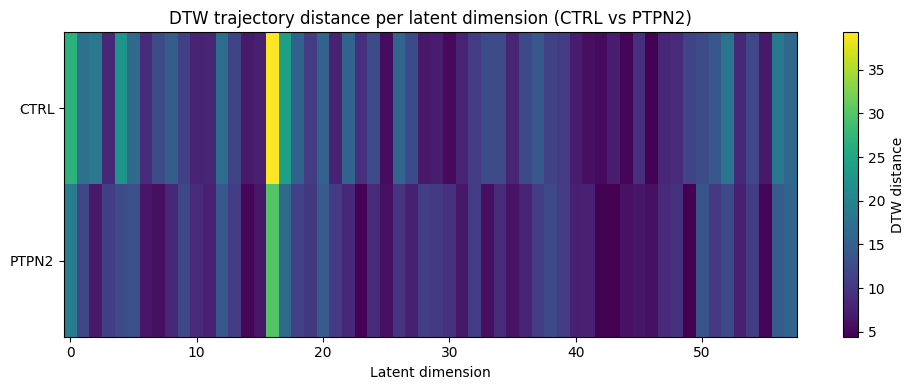

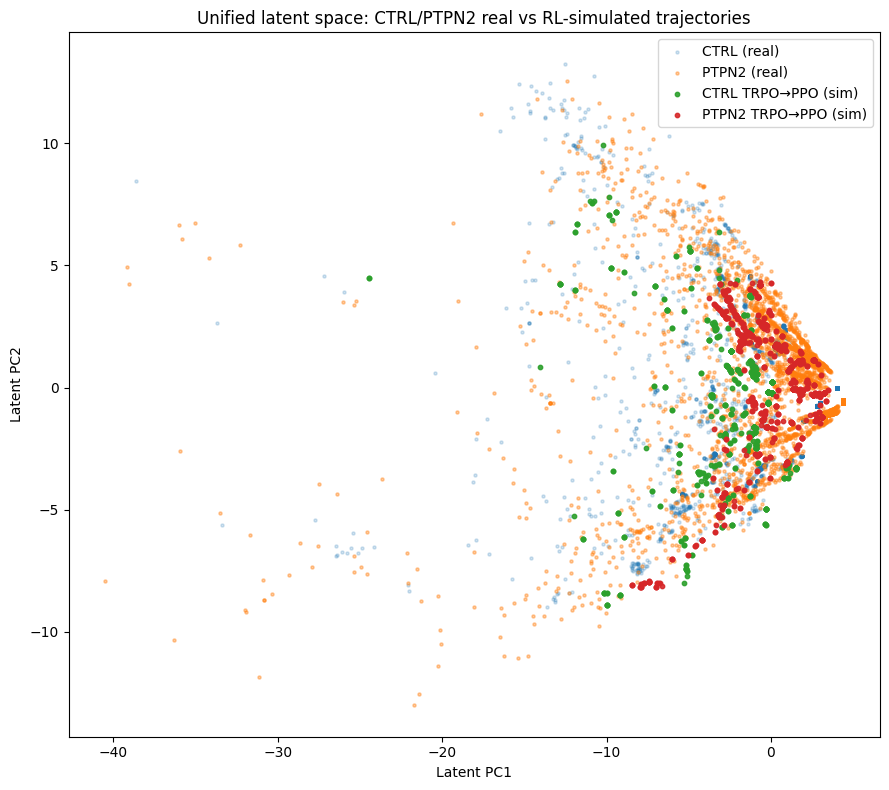

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [2]:
# ============================================================
# Unified CTRL + PTPN2 CRISPR RL (Model-based + Model-free)
#
# Encoder:
#   - Align genes (CTRL, PTPN2)
#   - True 80/20 split on PTPN2 BEFORE preprocessing
#   - HVG on PTPN2-TRAIN only → applied to PTPN2-TEST + CTRL
#   - Gene Autoencoder (PTPN2-TRAIN only)
#   - PCA (PTPN2-TRAIN only, applied to all)
#   - Simple inference-only GAT on joint PCA space
#
# RL:
#   - PTPN2: model-based RL with world model f_θ, perturb once at t=0
#   - CTRL: model-free RL, multi-step perturbation (additive updates)
#
# Evaluation:
#   - Single-dim metrics (Accuracy, F1, MSE, RMSE, MAE, R2, Pearson, AUPRC)
#   - Distance to REAL PTPN2 TRAIN mean
#   - Pseudotime alignment (mapped to PTPN2 pseudotime)
#   - IQCELL-style:
#       * Full H-step trajectories (mean simulated vs experimental)
#       * DTW per latent dimension
#       * 1D Wasserstein (OT) per dimension
#       * DTW heatmap (CTRL vs PTPN2)
#       * Combined similarity table (CSV)
# ============================================================

import numpy as np
import pandas as pd
import scipy.io as sio
from scipy import sparse
from scipy.spatial.distance import cdist
from scipy.stats import wasserstein_distance
import math
import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad

import gymnasium as gym
from gymnasium import spaces

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, mean_absolute_error, r2_score,
    average_precision_score
)
from sklearn.decomposition import PCA

import torch
import torch.nn as nn

from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.env_checker import check_env


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# ============================================================
# 1. PATHS / HYPERPARAMETERS
# ============================================================

CTRL_MATRIX = "GSM3937878_ctrl_matrix.mtx"
CTRL_FEAT   = "GSM3937878_ctrl_features.tsv"

PTPN2_MATRIX = "GSM3937879_Ptpn2_matrix.mtx"
PTPN2_FEAT   = "GSM3937879_Ptpn2_features.tsv"

# Encoder
N_TOP_GENES   = 20
GENE_EMB_DIM  = 16
N_PCS         = 10
GAT_OUT_DIM   = 32

# World model
WORLD_HIDDEN  = 128
K_NEXT        = 5
WORLD_EPOCHS  = 50
WORLD_LR      = 1e-3

# RL
ACTION_SCALE  = 0.3
HORIZON       = 12    # multi-step length for both systems

PPO_TIMESTEPS_BASELINE = 150_000
TRPO_TIMESTEPS_STAGE1  = 10_000
PPO_TIMESTEPS_STAGE2   = 140_000

ROLLOUT_SAMPLES = 1500       # for metrics (start vs final)
N_TRAJ_DTW      = 128        # for DTW/OT trajectory analysis

# Training hyperparams
AE_EPOCHS       = 30
BATCH_SIZE      = 256

ALPHA           = 0.5  # for CTRL in-silico target


# ============================================================
# 2. LOAD CTRL & PTPN2 MATRICES + ALIGN GENES
# ============================================================

def load_mtx(mtx_path, feat_path):
    X = sio.mmread(mtx_path)
    if not sparse.isspmatrix(X):
        X = sparse.coo_matrix(X)
    X = X.T.tocsr()  # cells x genes
    genes = pd.read_csv(feat_path, sep="\t", header=None).iloc[:, 0].astype(str).values
    return X, genes

ctrl_X_raw, ctrl_genes   = load_mtx(CTRL_MATRIX, CTRL_FEAT)
ptpn2_X_raw, ptpn2_genes = load_mtx(PTPN2_MATRIX, PTPN2_FEAT)

common_genes, idx_ctrl, idx_ptpn2 = np.intersect1d(
    ctrl_genes, ptpn2_genes, return_indices=True
)

ctrl_X_raw  = ctrl_X_raw[:, idx_ctrl]
ptpn2_X_raw = ptpn2_X_raw[:, idx_ptpn2]
genes_common = common_genes

print("CTRL raw:", ctrl_X_raw.shape, "PTPN2 raw:", ptpn2_X_raw.shape)
print("Common genes:", len(genes_common))

X_ctrl   = ctrl_X_raw.toarray().astype(np.float32)
X_ptpn2  = ptpn2_X_raw.toarray().astype(np.float32)


# ============================================================
# 3. TRUE 80/20 PTPN2 SPLIT (BEFORE ANY PREPROCESSING)
# ============================================================

X_ptpn2_train_raw, X_ptpn2_test_raw = train_test_split(
    X_ptpn2, test_size=0.20, random_state=42, shuffle=True
)

print("PTPN2 train raw:", X_ptpn2_train_raw.shape)
print("PTPN2 test raw:",  X_ptpn2_test_raw.shape)


# ============================================================
# 4. HVG ON PTPN2 TRAIN ONLY, APPLY TO TEST + CTRL
# ============================================================

adata_ptpn2_train = ad.AnnData(X_ptpn2_train_raw)
adata_ptpn2_train.var_names = genes_common

# Train-only normalization, HVG, scaling
sc.pp.normalize_total(adata_ptpn2_train, target_sum=1e4)
sc.pp.log1p(adata_ptpn2_train)
sc.pp.highly_variable_genes(adata_ptpn2_train, n_top_genes=N_TOP_GENES, subset=True)
sc.pp.scale(adata_ptpn2_train, max_value=10)

hvg_genes = adata_ptpn2_train.var_names
print("HVG genes (PTPN2 train):", len(hvg_genes))

hvg_mask = np.isin(genes_common, hvg_genes)

# Apply to PTPN2 test
adata_ptpn2_test = ad.AnnData(X_ptpn2_test_raw[:, hvg_mask])
adata_ptpn2_test.var_names = hvg_genes
sc.pp.normalize_total(adata_ptpn2_test, target_sum=1e4)
sc.pp.log1p(adata_ptpn2_test)
sc.pp.scale(adata_ptpn2_test, max_value=10)

# Apply to CTRL
adata_ctrl = ad.AnnData(X_ctrl[:, hvg_mask])
adata_ctrl.var_names = hvg_genes
sc.pp.normalize_total(adata_ctrl, target_sum=1e4)
sc.pp.log1p(adata_ctrl)
sc.pp.scale(adata_ctrl, max_value=10)

print("PTPN2 train HVG:", adata_ptpn2_train.shape)
print("PTPN2 test HVG:",  adata_ptpn2_test.shape)
print("CTRL HVG:",         adata_ctrl.shape)

X_ptpn2_train = adata_ptpn2_train.X.astype(np.float32)
X_ptpn2_test  = adata_ptpn2_test.X.astype(np.float32)
X_ctrl_hvg    = adata_ctrl.X.astype(np.float32)


# ============================================================
# 5. GENE AUTOENCODER (PTPN2 TRAIN ONLY)
# ============================================================

n_ptpn2_train, n_genes = X_ptpn2_train.shape
print("Autoencoder input:", X_ptpn2_train.shape)

class GeneAutoencoder(nn.Module):
    def __init__(self, in_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, in_dim)
        )

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

ae = GeneAutoencoder(n_genes, GENE_EMB_DIM).to(DEVICE)
ae_opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
ae_loss_fn = nn.MSELoss()

X_ptpn2_train_tensor = torch.tensor(X_ptpn2_train, dtype=torch.float32, device=DEVICE)
X_ptpn2_test_tensor  = torch.tensor(X_ptpn2_test,  dtype=torch.float32, device=DEVICE)
X_ctrl_tensor        = torch.tensor(X_ctrl_hvg,    dtype=torch.float32, device=DEVICE)

ae.train()
for epoch in range(AE_EPOCHS):
    perm = torch.randperm(n_ptpn2_train, device=DEVICE)
    total = 0.0
    for i in range(0, n_ptpn2_train, BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch = X_ptpn2_train_tensor[idx]
        ae_opt.zero_grad()
        recon, _ = ae(batch)
        loss = ae_loss_fn(recon, batch)
        loss.backward()
        ae_opt.step()
        total += loss.item() * batch.size(0)
    if (epoch+1) % 5 == 0:
        print(f"[AE] Epoch {epoch+1}/{AE_EPOCHS} | Loss={total/n_ptpn2_train:.4f}")

ae.eval()
with torch.no_grad():
    Z_ptpn2_train = ae.encode(X_ptpn2_train_tensor).cpu().numpy()
    Z_ptpn2_test  = ae.encode(X_ptpn2_test_tensor).cpu().numpy()
    Z_ctrl        = ae.encode(X_ctrl_tensor).cpu().numpy()

print("Gene emb PTPN2 train:", Z_ptpn2_train.shape)
print("Gene emb PTPN2 test:",  Z_ptpn2_test.shape)
print("Gene emb CTRL:",        Z_ctrl.shape)


# ============================================================
# 6. PCA (PTPN2 TRAIN → OTHERS)
# ============================================================

pca_model = PCA(n_components=N_PCS)
X_pca_ptpn2_train = pca_model.fit_transform(Z_ptpn2_train)
X_pca_ptpn2_test  = pca_model.transform(Z_ptpn2_test)
X_pca_ctrl        = pca_model.transform(Z_ctrl)

print("PCA PTPN2 train:", X_pca_ptpn2_train.shape)
print("PCA PTPN2 test:",  X_pca_ptpn2_test.shape)
print("PCA CTRL:",        X_pca_ctrl.shape)


# ============================================================
# 7. SIMPLE INFERENCE-ONLY GAT ON JOINT PCA SPACE
# ============================================================

class SimpleGATLayer(nn.Module):
    def __init__(self, in_dim, out_dim, neighbor_lists, alpha=0.2):
        super().__init__()
        self.neighbors = neighbor_lists
        self.W = nn.Parameter(torch.Tensor(in_dim, out_dim))
        self.a = nn.Parameter(torch.Tensor(2*out_dim, 1))
        self.leaky = nn.LeakyReLU(alpha)
        nn.init.xavier_uniform_(self.W)
        nn.init.xavier_uniform_(self.a)

    def forward(self, X):
        Wh = X @ self.W
        out = torch.zeros_like(Wh)
        for i in range(Wh.shape[0]):
            neigh = self.neighbors[i]
            h_i = Wh[i]
            h_j = Wh[neigh]
            k = len(neigh)
            a_in = torch.cat([h_i.expand(k, -1), h_j], dim=1)
            e = self.leaky(a_in @ self.a).squeeze(-1)
            alpha = torch.softmax(e, dim=0)
            out[i] = (alpha.unsqueeze(1) * h_j).sum(0)
        return out

# Build combined PCA for graph
X_pca_full = np.vstack([X_pca_ptpn2_train, X_pca_ptpn2_test, X_pca_ctrl])
n_tr   = X_pca_ptpn2_train.shape[0]
n_te   = X_pca_ptpn2_test.shape[0]
n_ctrl = X_pca_ctrl.shape[0]

adata_pca_full = ad.AnnData(X_pca_full)
adata_pca_full.obsm["X_pca"] = X_pca_full
sc.pp.neighbors(adata_pca_full, n_neighbors=15, use_rep="X_pca")
A_full = adata_pca_full.obsp["connectivities"].tocsr()

neighbor_lists_full = []
for i in range(A_full.shape[0]):
    neigh = A_full[i].indices
    if i not in neigh:
        neigh = np.append(neigh, i)
    neighbor_lists_full.append(neigh)

gat_layer = SimpleGATLayer(N_PCS, GAT_OUT_DIM, neighbor_lists_full).to(DEVICE)

with torch.no_grad():
    X_gat_full = gat_layer(
        torch.tensor(X_pca_full, dtype=torch.float32, device=DEVICE)
    ).cpu().numpy()

X_gat_ptpn2_train = X_gat_full[:n_tr]
X_gat_ptpn2_test  = X_gat_full[n_tr:n_tr+n_te]
X_gat_ctrl        = X_gat_full[n_tr+n_te:]

print("GAT PTPN2 train:", X_gat_ptpn2_train.shape)
print("GAT PTPN2 test:",  X_gat_ptpn2_test.shape)
print("GAT CTRL:",        X_gat_ctrl.shape)


# ============================================================
# 8. FUSED EMBEDDINGS (SHARED LATENT SPACE)
# ============================================================

emb_ptpn2_train = np.concatenate([Z_ptpn2_train, X_pca_ptpn2_train, X_gat_ptpn2_train], axis=1)
emb_ptpn2_test  = np.concatenate([Z_ptpn2_test,  X_pca_ptpn2_test,  X_gat_ptpn2_test],  axis=1)
emb_ctrl        = np.concatenate([Z_ctrl,        X_pca_ctrl,        X_gat_ctrl],        axis=1)

emb_ptpn2_all = np.vstack([emb_ptpn2_train, emb_ptpn2_test])

print("Fused PTPN2 train:", emb_ptpn2_train.shape)
print("Fused PTPN2 test:",  emb_ptpn2_test.shape)
print("Fused CTRL:",        emb_ctrl.shape)


# ============================================================
# 9. PSEUDOTIME (PTPN2 TRAIN) + MAPPING TO PTPN2 TEST & CTRL
# ============================================================

# DPT on PTPN2 TRAIN (using HVG expression)
sc.pp.neighbors(adata_ptpn2_train, n_neighbors=15, use_rep=None)
sc.tl.diffmap(adata_ptpn2_train)
adata_ptpn2_train.uns["iroot"] = len(adata_ptpn2_train) // 2
sc.tl.dpt(adata_ptpn2_train)
pt_ptpn2_train = adata_ptpn2_train.obs["dpt_pseudotime"].values
print("PTPN2 train pseudotime:", pt_ptpn2_train.shape)

def map_to_pseudotime(ref_emb, ref_pt, X):
    d = cdist(X, ref_emb)
    nn = d.argmin(axis=1)
    return ref_pt[nn]

pt_ptpn2_test = map_to_pseudotime(emb_ptpn2_train, pt_ptpn2_train, emb_ptpn2_test)
pt_ctrl       = map_to_pseudotime(emb_ptpn2_train, pt_ptpn2_train, emb_ctrl)

print("PTPN2 test pseudotime (mapped):", pt_ptpn2_test.shape)
print("CTRL pseudotime (mapped):",       pt_ctrl.shape)

# -------- Pseudotime cleaning (avoid NaNs/Inf) --------

def clean_pseudotime(pt):
    pt = np.array(pt, dtype=float)
    mask = np.isfinite(pt)
    if mask.sum() == 0:
        raise ValueError("All pseudotime values invalid after mapping!")
    mean_val = np.nanmean(pt[mask])
    pt[~mask] = mean_val
    return pt

pt_ptpn2_train = clean_pseudotime(pt_ptpn2_train)
pt_ptpn2_test  = clean_pseudotime(pt_ptpn2_test)
pt_ctrl        = clean_pseudotime(pt_ctrl)

pt_ptpn2_all = np.concatenate([pt_ptpn2_train, pt_ptpn2_test], axis=0)


# ============================================================
# 10. WORLD MODEL f_θ (PTPN2 TRAIN, kNN NEXT-STEP)
# ============================================================

def build_world_model_pairs(emb, pt, k=5, min_delta=1e-4):
    n = emb.shape[0]
    X_curr, X_next = [], []
    for i in range(n):
        mask = pt > pt[i] + min_delta
        cand_idx = np.where(mask)[0]
        if len(cand_idx) < k:
            continue
        cand_emb = emb[cand_idx]
        dists = np.linalg.norm(cand_emb - emb[i], axis=1)
        nn_rel = np.argsort(dists)[:k]
        nn_abs = cand_idx[nn_rel]
        x_next = emb[nn_abs].mean(axis=0)
        X_curr.append(emb[i])
        X_next.append(x_next)
    X_curr = np.vstack(X_curr)
    X_next = np.vstack(X_next)
    return X_curr, X_next

X_curr_wm, X_next_wm = build_world_model_pairs(
    emb_ptpn2_train, pt_ptpn2_train, k=K_NEXT
)
print("World model pairs:", X_curr_wm.shape, X_next_wm.shape)

class WorldModel(nn.Module):
    def __init__(self, dim, hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, dim)
        )

    def forward(self, x):
        return self.net(x)

world_dim = emb_ptpn2_train.shape[1]
world_model = WorldModel(world_dim, WORLD_HIDDEN).to(DEVICE)
world_opt = torch.optim.Adam(world_model.parameters(), lr=WORLD_LR)
world_loss_fn = nn.MSELoss()

X_curr_tensor = torch.tensor(X_curr_wm, dtype=torch.float32, device=DEVICE)
X_next_tensor = torch.tensor(X_next_wm, dtype=torch.float32, device=DEVICE)

world_model.train()
for epoch in range(WORLD_EPOCHS):
    perm = torch.randperm(X_curr_wm.shape[0], device=DEVICE)
    total = 0.0
    for i in range(0, X_curr_wm.shape[0], BATCH_SIZE):
        idx = perm[i:i+BATCH_SIZE]
        batch_curr = X_curr_tensor[idx]
        batch_next = X_next_tensor[idx]
        world_opt.zero_grad()
        pred_next = world_model(batch_curr)
        loss = world_loss_fn(pred_next, batch_next)
        loss.backward()
        world_opt.step()
        total += loss.item() * batch_curr.size(0)
    print(f"[WORLD] Epoch {epoch+1}/{WORLD_EPOCHS} | Loss={total/X_curr_wm.shape[0]:.4f}")

world_model.eval()


# ============================================================
# 11. TARGETS + CTRL 80/20 SPLIT
# ============================================================

# PTPN2 real target
target_ptpn2_real = emb_ptpn2_train.mean(axis=0)
print("Target latent dim (PTPN2):", target_ptpn2_real.shape)

# CTRL 80/20 split in fused latent space for model-free RL
emb_ctrl_train, emb_ctrl_test, pt_ctrl_train, pt_ctrl_test = train_test_split(
    emb_ctrl, pt_ctrl, test_size=0.20, random_state=42, shuffle=True
)

mu_ctrl_train  = emb_ctrl_train.mean(axis=0)
std_ctrl_train = emb_ctrl_train.std(axis=0)
insilico_target_ctrl = mu_ctrl_train - ALPHA * std_ctrl_train


# ============================================================
# 12. MODEL-BASED RL ENV (PTPN2WorldEnv)
# ============================================================

class PTPN2WorldEnv(gym.Env):
    """
    Model-based RL on PTPN2:
      - State: fused PTPN2 latent
      - t=0: RL applies one perturbation (action)
      - t>0: state evolves via world model f_θ
      - Reward: -||state - target||^2
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, emb, target, world_model, horizon=12, action_scale=0.3):
        super().__init__()
        self.emb = emb.astype(np.float32)
        self.target = target.astype(np.float32)
        self.world_model = world_model
        self.horizon = horizon
        self.action_scale = action_scale
        self.n, self.dim = self.emb.shape

        self.action_space = spaces.Box(-1.0, 1.0, (self.dim,), np.float32)
        self.observation_space = spaces.Box(-np.inf, np.inf, (self.dim,), np.float32)

        self.state = None
        self.t = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        idx = np.random.randint(0, self.n)
        self.state = self.emb[idx].copy()
        self.t = 0
        return self.state, {}

    def step(self, action):
        if self.t == 0:
            action = np.clip(action, -1, 1)
            next_state = self.state + self.action_scale * action
        else:
            with torch.no_grad():
                s = torch.tensor(self.state, dtype=torch.float32, device=DEVICE).unsqueeze(0)
                next_state = self.world_model(s).cpu().numpy()[0]

        diff = next_state - self.target

        # IMPORTANT FIX
        reward = float(-np.dot(diff, diff))

        self.state = next_state
        self.t += 1
        terminated = self.t >= self.horizon
        truncated = False
        return next_state, reward, terminated, truncated, {}



env_ptpn2_train = PTPN2WorldEnv(
    emb_ptpn2_train, target_ptpn2_real, world_model,
    horizon=HORIZON, action_scale=ACTION_SCALE
)
env_ptpn2_test  = PTPN2WorldEnv(
    emb_ptpn2_test,  target_ptpn2_real, world_model,
    horizon=HORIZON, action_scale=ACTION_SCALE
)

check_env(env_ptpn2_train)


# ============================================================
# 13. MODEL-FREE RL ENV (CRISPRCtrlEnv) ON CTRL
# ============================================================

class CRISPRCtrlEnv(gym.Env):
    """
    Model-free RL on CTRL:
      - State: fused CTRL latent
      - Multi-step: x_{t+1} = x_t + scale * a_t
      - Reward: -||state - target||^2 - small L2(action)
    """
    metadata = {"render_modes": ["human"]}

    def __init__(self, ctrl_emb, ptime, target, scale=0.3, horizon=12):
        super().__init__()
        self.ctrl = ctrl_emb.astype(np.float32)
        self.pseudotime = np.array(ptime, dtype=float)
        self.target = target.astype(np.float32)
        self.scale = scale
        self.horizon = horizon
        self.n_cells, self.dim = self.ctrl.shape

        self.action_space = spaces.Box(-1.0, 1.0, (self.dim,), np.float32)
        self.observation_space = spaces.Box(-np.inf, np.inf, (self.dim,), np.float32)

        self.state = None
        self.t = 0

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)

        probs = np.array(self.pseudotime, dtype=float)
        # Remove NaN/inf
        probs[~np.isfinite(probs)] = 0.0
        probs = probs + 1e-6
        total = probs.sum()
        if total == 0 or not np.isfinite(total):
            probs = np.ones_like(probs) / len(probs)
        else:
            probs = probs / total

        idx = np.random.choice(self.n_cells, p=probs)
        self.state = self.ctrl[idx].copy()
        self.t = 0
        return self.state, {}

    def step(self, action):
        action = np.clip(action, -1, 1)
        next_state = self.state + self.scale * action
        diff = next_state - self.target

        # IMPORTANT FIX
        reward = float(-np.dot(diff, diff) - 0.01 * np.linalg.norm(action))

        self.state = next_state
        self.t += 1
        terminated = self.t >= self.horizon
        truncated = False
        return next_state, reward, terminated, truncated, {}



env_ctrl_train = CRISPRCtrlEnv(
    emb_ctrl_train, pt_ctrl_train,
    insilico_target_ctrl, scale=ACTION_SCALE, horizon=HORIZON
)
env_ctrl_test  = CRISPRCtrlEnv(
    emb_ctrl_test,  pt_ctrl_test,
    target_ptpn2_real, scale=ACTION_SCALE, horizon=HORIZON
)

check_env(env_ctrl_train)


# ============================================================
# 14. RL TRAINING: PPO / TRPO / TRPO→PPO
# ============================================================

# ---- CTRL model-free RL ----
ppo_ctrl = PPO("MlpPolicy", env_ctrl_train, verbose=1)
ppo_ctrl.learn(PPO_TIMESTEPS_BASELINE)

trpo_ctrl = TRPO("MlpPolicy", env_ctrl_train, verbose=1)
trpo_ctrl.learn(TRPO_TIMESTEPS_STAGE1)

ppo_ctrl_ms = PPO("MlpPolicy", env_ctrl_train, verbose=1)
ppo_ctrl_ms.policy.load_state_dict(trpo_ctrl.policy.state_dict())
ppo_ctrl_ms.learn(PPO_TIMESTEPS_STAGE2)

# ---- PTPN2 model-based RL ----
ppo_ptpn2 = PPO("MlpPolicy", env_ptpn2_train, verbose=1)
ppo_ptpn2.learn(PPO_TIMESTEPS_BASELINE)

trpo_ptpn2 = TRPO("MlpPolicy", env_ptpn2_train, verbose=1)
trpo_ptpn2.learn(TRPO_TIMESTEPS_STAGE1)

ppo_ptpn2_ms = PPO("MlpPolicy", env_ptpn2_train, verbose=1)
ppo_ptpn2_ms.policy.load_state_dict(trpo_ptpn2.policy.state_dict())
ppo_ptpn2_ms.learn(PPO_TIMESTEPS_STAGE2)


# ============================================================
# 15. MULTI-STEP ROLLOUTS (START vs FINAL) FOR METRICS
# ============================================================

def rollout_last(agent, env, n_samples=1000):
    raw, shifted, rewards = [], [], []
    for _ in range(n_samples):
        obs, _ = env.reset()
        start = obs.copy()
        total_r = 0.0
        for _ in range(env.horizon):
            a, _ = agent.predict(obs, deterministic=True)
            obs, r, done, _, _ = env.step(a)
            total_r += r
            if done:
                break
        raw.append(start)
        shifted.append(obs.copy())
        rewards.append(total_r)
    return np.vstack(raw), np.vstack(shifted), np.array(rewards)

# CTRL env
raw_ctrl_ppo_tr,  shift_ctrl_ppo_tr,  rew_ctrl_ppo_tr  = rollout_last(ppo_ctrl,    env_ctrl_train, ROLLOUT_SAMPLES)
raw_ctrl_ppo_te,  shift_ctrl_ppo_te,  rew_ctrl_ppo_te  = rollout_last(ppo_ctrl,    env_ctrl_test,  ROLLOUT_SAMPLES)
raw_ctrl_ms_tr,   shift_ctrl_ms_tr,   rew_ctrl_ms_tr   = rollout_last(ppo_ctrl_ms, env_ctrl_train, ROLLOUT_SAMPLES)
raw_ctrl_ms_te,   shift_ctrl_ms_te,   rew_ctrl_ms_te   = rollout_last(ppo_ctrl_ms, env_ctrl_test,  ROLLOUT_SAMPLES)
raw_ctrl_trpo_tr, shift_ctrl_trpo_tr, rew_ctrl_trpo_tr = rollout_last(trpo_ctrl,   env_ctrl_train, ROLLOUT_SAMPLES)
raw_ctrl_trpo_te, shift_ctrl_trpo_te, rew_ctrl_trpo_te = rollout_last(trpo_ctrl,   env_ctrl_test,  ROLLOUT_SAMPLES)

# PTPN2 env
raw_ptpn2_ppo_tr,  shift_ptpn2_ppo_tr,  rew_ptpn2_ppo_tr  = rollout_last(ppo_ptpn2,    env_ptpn2_train, ROLLOUT_SAMPLES)
raw_ptpn2_ppo_te,  shift_ptpn2_ppo_te,  rew_ptpn2_ppo_te  = rollout_last(ppo_ptpn2,    env_ptpn2_test,  ROLLOUT_SAMPLES)
raw_ptpn2_ms_tr,   shift_ptpn2_ms_tr,   rew_ptpn2_ms_tr   = rollout_last(ppo_ptpn2_ms, env_ptpn2_train, ROLLOUT_SAMPLES)
raw_ptpn2_ms_te,   shift_ptpn2_ms_te,   rew_ptpn2_ms_te   = rollout_last(ppo_ptpn2_ms, env_ptpn2_test,  ROLLOUT_SAMPLES)
raw_ptpn2_trpo_tr, shift_ptpn2_trpo_tr, rew_ptpn2_trpo_tr = rollout_last(trpo_ptpn2,   env_ptpn2_train, ROLLOUT_SAMPLES)
raw_ptpn2_trpo_te, shift_ptpn2_trpo_te, rew_ptpn2_trpo_te = rollout_last(trpo_ptpn2,   env_ptpn2_test,  ROLLOUT_SAMPLES)


# ============================================================
# 16. METRICS (PER DIM + MEAN)
# ============================================================

def metrics_1d(true_vals, pred_vals):
    m = {}
    y_true = (true_vals > 0).astype(int)
    y_pred = (pred_vals > 0).astype(int)
    m["Accuracy"]  = accuracy_score(y_true, y_pred)
    m["Precision"] = precision_score(y_true, y_pred, zero_division=0)
    m["Recall"]    = recall_score(y_true, y_pred, zero_division=0)
    m["F1"]        = f1_score(y_true, y_pred, zero_division=0)
    try:
        m["AUPRC"] = average_precision_score(y_true, y_pred)
    except Exception:
        m["AUPRC"] = np.nan
    mse = mean_squared_error(true_vals, pred_vals)
    m["MSE"]  = mse
    m["RMSE"] = math.sqrt(mse)
    m["MAE"]  = mean_absolute_error(true_vals, pred_vals)
    m["R2"]   = r2_score(true_vals, pred_vals)
    if np.std(true_vals) == 0:
        m["Pearson"] = 0.0
    else:
        m["Pearson"] = np.corrcoef(true_vals, pred_vals)[0, 1]
    return m

def eval_model(raw, shifted, algo_name, system_name):
    rows = []
    D = raw.shape[1]
    for d in range(D):
        md = metrics_1d(raw[:, d], shifted[:, d])
        md["Dim"] = d
        md["Algorithm"] = algo_name
        md["System"] = system_name
        rows.append(md)
    return pd.DataFrame(rows)

dfs = []

# CTRL
dfs.append(eval_model(raw_ctrl_ppo_tr,  shift_ctrl_ppo_tr,  "PPO (Train)",      "CTRL"))
dfs.append(eval_model(raw_ctrl_ppo_te,  shift_ctrl_ppo_te,  "PPO (Test)",       "CTRL"))
dfs.append(eval_model(raw_ctrl_ms_tr,   shift_ctrl_ms_tr,   "TRPO→PPO (Train)", "CTRL"))
dfs.append(eval_model(raw_ctrl_ms_te,   shift_ctrl_ms_te,   "TRPO→PPO (Test)",  "CTRL"))
dfs.append(eval_model(raw_ctrl_trpo_tr, shift_ctrl_trpo_tr, "TRPO (Train)",     "CTRL"))
dfs.append(eval_model(raw_ctrl_trpo_te, shift_ctrl_trpo_te, "TRPO (Test)",      "CTRL"))

# PTPN2
dfs.append(eval_model(raw_ptpn2_ppo_tr,  shift_ptpn2_ppo_tr,  "PPO (Train)",      "PTPN2"))
dfs.append(eval_model(raw_ptpn2_ppo_te,  shift_ptpn2_ppo_te,  "PPO (Test)",       "PTPN2"))
dfs.append(eval_model(raw_ptpn2_ms_tr,   shift_ptpn2_ms_tr,   "TRPO→PPO (Train)", "PTPN2"))
dfs.append(eval_model(raw_ptpn2_ms_te,   shift_ptpn2_ms_te,   "TRPO→PPO (Test)",  "PTPN2"))
dfs.append(eval_model(raw_ptpn2_trpo_tr, shift_ptpn2_trpo_tr, "TRPO (Train)",     "PTPN2"))
dfs.append(eval_model(raw_ptpn2_trpo_te, shift_ptpn2_trpo_te, "TRPO (Test)",      "PTPN2"))

df_all = pd.concat(dfs, axis=0)
df_all.to_csv("unified_ctrl_ptpn2_rl_single_dim_metrics.csv", index=False)

metric_cols = ["Accuracy","Precision","Recall","F1","AUPRC","MSE","RMSE","MAE","R2","Pearson"]
df_mean = df_all.groupby(["System","Algorithm"])[metric_cols].mean()
df_mean.to_csv("unified_ctrl_ptpn2_rl_mean_metrics.csv")

print("\n=== MEAN METRICS (by System, Algorithm) ===")
print(df_mean)


# ============================================================
# 17. DISTANCE TO REAL PTPN2 MEAN (TEST TRAJECTORIES)
# ============================================================

def mean_dist(X, target):
    return np.linalg.norm(X - target[None, :], axis=1).mean()

print("\n=== Distance to REAL PTPN2 TRAIN mean (TRPO→PPO, Test) ===")
print("CTRL TRPO→PPO:",  mean_dist(shift_ctrl_ms_te,   target_ptpn2_real))
print("PTPN2 TRPO→PPO:", mean_dist(shift_ptpn2_ms_te, target_ptpn2_real))


# ============================================================
# 18. PSEUDOTIME ALIGNMENT FOR SIMULATED TRAJECTORIES
# ============================================================

pt_ctrl_ms_test   = map_to_pseudotime(emb_ptpn2_train, pt_ptpn2_train, shift_ctrl_ms_te)
pt_ptpn2_ms_test  = map_to_pseudotime(emb_ptpn2_train, pt_ptpn2_train, shift_ptpn2_ms_te)

print("\n=== Pseudotime alignment (TRPO→PPO, Test) ===")
print(f"CTRL TRPO→PPO:   mean={pt_ctrl_ms_test.mean():.3f}, std={pt_ctrl_ms_test.std():.3f}")
print(f"PTPN2 TRPO→PPO:  mean={pt_ptpn2_ms_test.mean():.3f}, std={pt_ptpn2_ms_test.std():.3f}")


# ============================================================
# 19. FULL H-STEP TRAJECTORIES FOR IQCELL-STYLE COMPARISON
# ============================================================

def rollout_trajectories(agent, env, n_traj):
    """
    Collect full trajectories: shape (n_traj, horizon+1, dim)
    """
    trajs = []
    for _ in range(n_traj):
        obs, _ = env.reset()
        traj = [obs.copy()]
        for _ in range(env.horizon):
            a, _ = agent.predict(obs, deterministic=True)
            obs, r, done, _, _ = env.step(a)
            traj.append(obs.copy())
            if done:
                break
        # pad if shorter than horizon+1
        if len(traj) < env.horizon + 1:
            last = traj[-1].copy()
            while len(traj) < env.horizon + 1:
                traj.append(last.copy())
        trajs.append(np.stack(traj, axis=0))
    return np.stack(trajs, axis=0)  # (N, T, D)

# TRPO→PPO trajectories on TEST envs
traj_ctrl_ms_te  = rollout_trajectories(ppo_ctrl_ms,  env_ctrl_test,  N_TRAJ_DTW)
traj_ptpn2_ms_te = rollout_trajectories(ppo_ptpn2_ms, env_ptpn2_test, N_TRAJ_DTW)

traj_ctrl_mean   = traj_ctrl_ms_te.mean(axis=0)    # (T, D)
traj_ptpn2_mean  = traj_ptpn2_ms_te.mean(axis=0)   # (T, D)


# ============================================================
# 20. EXPERIMENTAL TRAJECTORIES (PSEUDOTIME-SORTED)
# ============================================================

def build_exp_trajectory(emb, pt, n_points):
    """
    Build experimental trajectory by:
      - sorting cells by pseudotime
      - sampling n_points along that ordering
    """
    order = np.argsort(pt)
    emb_sorted = emb[order]
    L = emb_sorted.shape[0]
    idx = np.linspace(0, L-1, n_points).astype(int)
    return emb_sorted[idx]

T_traj = HORIZON + 1

exp_traj_ctrl  = build_exp_trajectory(emb_ctrl,       pt_ctrl,        T_traj)
exp_traj_ptpn2 = build_exp_trajectory(emb_ptpn2_all,  pt_ptpn2_all,   T_traj)


# ============================================================
# 21. DTW + WASSERSTEIN (OT) TRAJECTORY SIMILARITY
# ============================================================

def dtw_distance_1d(x, y):
    """
    Simple DTW for 1D sequences x, y.
    """
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    n, m = len(x), len(y)
    D = np.full((n+1, m+1), np.inf)
    D[0, 0] = 0.0
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(x[i-1] - y[j-1])
            D[i, j] = cost + min(D[i-1, j], D[i, j-1], D[i-1, j-1])
    return D[n, m]

results_traj = []

for system, traj_sim_mean, traj_exp in [
    ("CTRL",  traj_ctrl_mean,  exp_traj_ctrl),
    ("PTPN2", traj_ptpn2_mean, exp_traj_ptpn2),
]:
    D_latent = traj_sim_mean.shape[1]
    for d in range(D_latent):
        sim_seq = traj_sim_mean[:, d]
        exp_seq = traj_exp[:, d]
        dtw_val = dtw_distance_1d(sim_seq, exp_seq)
        wdist  = wasserstein_distance(sim_seq, exp_seq)
        results_traj.append({
            "System": system,
            "Dim": d,
            "DTW": dtw_val,
            "Wasserstein": wdist
        })

df_traj = pd.DataFrame(results_traj)
df_traj.to_csv("trajectory_similarity_metrics_dtw_wasserstein.csv", index=False)

print("\n=== Trajectory similarity (mean DTW / Wasserstein) ===")
print(df_traj.groupby("System")[["DTW","Wasserstein"]].mean())


# ============================================================
# 22. DTW HEATMAP (DIMENSION-WISE, CTRL vs PTPN2)
# ============================================================

dtw_ctrl  = df_traj[df_traj["System"]=="CTRL"].sort_values("Dim")["DTW"].values
dtw_ptpn2 = df_traj[df_traj["System"]=="PTPN2"].sort_values("Dim")["DTW"].values

# ensure same length
D_min = min(len(dtw_ctrl), len(dtw_ptpn2))
dtw_mat = np.vstack([dtw_ctrl[:D_min], dtw_ptpn2[:D_min]])

plt.figure(figsize=(10, 4))
plt.imshow(dtw_mat, aspect="auto")
plt.yticks([0,1], ["CTRL", "PTPN2"])
plt.xlabel("Latent dimension")
plt.colorbar(label="DTW distance")
plt.title("DTW trajectory distance per latent dimension (CTRL vs PTPN2)")
plt.tight_layout()
plt.show()


# ============================================================
# 23. 2D VISUALIZATION OF REAL vs SIMULATED MANIFOLDS
# ============================================================

X_vis = np.vstack([
    emb_ctrl,
    emb_ptpn2_all,
    shift_ctrl_ms_te,
    shift_ptpn2_ms_te
])
pca_vis = PCA(n_components=2)
X_vis_2d = pca_vis.fit_transform(X_vis)

n_ctrl_real   = emb_ctrl.shape[0]
n_ptpn2_real  = emb_ptpn2_all.shape[0]
n_sim_ctrl    = shift_ctrl_ms_te.shape[0]
n_sim_ptpn2   = shift_ptpn2_ms_te.shape[0]

idx_ctrl_real   = np.arange(0, n_ctrl_real)
idx_ptpn2_real  = np.arange(n_ctrl_real, n_ctrl_real + n_ptpn2_real)
idx_sim_ctrl    = np.arange(n_ctrl_real + n_ptpn2_real,
                            n_ctrl_real + n_ptpn2_real + n_sim_ctrl)
idx_sim_ptpn2   = np.arange(n_ctrl_real + n_ptpn2_real + n_sim_ctrl,
                            n_ctrl_real + n_ptpn2_real + n_sim_ctrl + n_sim_ptpn2)

plt.figure(figsize=(9, 8))
plt.scatter(X_vis_2d[idx_ctrl_real,0],  X_vis_2d[idx_ctrl_real,1],
            s=5, alpha=0.2, label="CTRL (real)")
plt.scatter(X_vis_2d[idx_ptpn2_real,0], X_vis_2d[idx_ptpn2_real,1],
            s=5, alpha=0.4, label="PTPN2 (real)")
plt.scatter(X_vis_2d[idx_sim_ctrl,0],   X_vis_2d[idx_sim_ctrl,1],
            s=10, alpha=0.9, label="CTRL TRPO→PPO (sim)")
plt.scatter(X_vis_2d[idx_sim_ptpn2,0],  X_vis_2d[idx_sim_ptpn2,1],
            s=10, alpha=0.9, label="PTPN2 TRPO→PPO (sim)")

plt.xlabel("Latent PC1")
plt.ylabel("Latent PC2")
plt.title("Unified latent space: CTRL/PTPN2 real vs RL-simulated trajectories")
plt.legend()
plt.tight_layout()
plt.show()
